In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1013. Microbiome Peanut Allergy/P1013.3. Analyses/P1013.4. Outcome Prediction/Output')
cur_date = "011026"

library(readxl)
library(tidyverse)
library(Hmisc)
library(ggsci)
library(ggrepel)
library(umap)
library(gtsummary)
library(ggpubr)
library(cowplot)
library(pheatmap)

# reading in files
saliva_df = data.frame(read_excel("Input/Processed_Saliva_Data_090525.xlsx")) %>%
    mutate(Age = as.numeric(Age), IgE = as.numeric(IgE))
stool_df = data.frame(read_excel("Input/Processed_Stool_Data_090525.xlsx")) %>%
    mutate(Age = as.numeric(Age), IgE = as.numeric(IgE))
saliva_paired_outcome_df = data.frame(read_excel("Input/Saliva_Adj_Paired_Outcome_011026.xlsx")) %>%
    filter(P.Adj < 0.1)
stool_paired_outcome_df = data.frame(read_excel("Input/Stool_Adj_Paired_Outcome_011026.xlsx")) %>%
    filter(P.Adj < 0.1)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units



Attaching package: ‘cowplot’


The following object is masked from ‘package:ggpubr’:

    get_legend


The following object is masked from ‘package:lubridate’:

    stamp




In [2]:
post_saliva_df = saliva_df  %>%
    filter(IgE_Binarized != 'Fail', Time_Point == 'Post') %>%
    mutate(Outcome = ifelse(Outcome == 'DS', 'F', Outcome)) %>%
    mutate(across(c(10:ncol(saliva_df)), ~ log(.x + 2))) %>%
    filter(Treatment == 'A') %>%
    # cleaning variable names here
    mutate(Outcome = ifelse(Outcome == "F", "Failure",
                                  ifelse(Outcome == "SU", "Sustained Unresponsiveness", Outcome))) %>%
    pivot_longer(cols = 10:ncol(saliva_df), names_to = 'Name', values_to = 'Value') %>%
    filter(Name %in% saliva_paired_outcome_df$Name) %>%
    pivot_wider(names_from = Name, values_from = Value) %>%
    column_to_rownames(var = "Sample_ID")

post_stool_df = stool_df  %>%
    filter(IgE_Binarized != 'Fail', Time_Point == 'Post') %>%
    mutate(Outcome = ifelse(Outcome == 'DS', 'F', Outcome)) %>%
    mutate(across(c(11:ncol(stool_df)), ~ log(.x + 2))) %>%
    filter(Treatment == 'A') %>%
    # cleaning variable names here
    mutate(Outcome = ifelse(Outcome == "F", "Failure",
                                  ifelse(Outcome == "SU", "Sustained Unresponsiveness", Outcome))) %>%
    pivot_longer(cols = 11:ncol(stool_df), names_to = 'Name', values_to = 'Value') %>%
    filter(Name %in% stool_paired_outcome_df$Name) %>%
    pivot_wider(names_from = Name, values_from = Value) %>%
    column_to_rownames(var = "Sample_ID")


head(post_stool_df)

,Original_Subject_ID,Original_Sample_ID,Subject_No,Time_Point,Treatment,Outcome,Age,IgE,IgE_Binarized,d__Bacteria.p__Actinobacteriota.c__Coriobacteriia.o__Coriobacteriales.f__Coriobacteriaceae.g__Collinsella.__,⋯,d__Bacteria.p__Firmicutes_D.c__Bacilli.o__Erysipelotrichales.f__Coprobacillaceae.g__Coprobacillus.s__Coprobacillus.cateniformis,d__Bacteria.p__Firmicutes_D.c__Bacilli.o__Haloplasmatales_A.f__Turicibacteraceae.g__Turicibacter.s__Turicibacter.sanguinis,d__Bacteria.p__Firmicutes_D.c__Bacilli.o__Lactobacillales.f__Aerococcaceae.g__Granulicatella.__,d__Bacteria.p__Firmicutes_D.c__Bacilli.o__Lactobacillales.f__Enterococcaceae.g__Enterococcus_A.__,d__Bacteria.p__Firmicutes_D.c__Bacilli.o__Staphylococcales.f__Staphylococcaceae.g__Staphylococcus.__,d__Bacteria.p__Patescibacteria.__.__.__.__.__,d__Bacteria.p__Patescibacteria.c__Saccharimonadia.o__Saccharimonadales.f__Nanosynbacteraceae.g__Nanosynbacter.s__,d__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Burkholderiales_595427.f__Burkholderiaceae_A_595427.g__Parasutterella.__,d__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Enterobacterales_A_737866.f__Enterobacteriaceae_A.__.__,d__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Enterobacterales_A_737866.f__Pasteurellaceae.g__Haemophilus_D_735815.__
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Post_1,FS001-02,FS001-02-36mo,1,Post,A,Failure,1.873973,14.20,Low,0.6931472,⋯,0.6931472,6.6783421,3.5263605,0.6931472,3.4657359,0.6931472,1.9459101,0.6931472,0.6931472,0.6931472
Post_3,FS001-05,FS001-05-36mo,3,Post,A,Failure,3.991781,9.59,Low,9.1432386,⋯,0.6931472,0.6931472,0.6931472,0.6931472,2.1972246,0.6931472,3.9702919,4.1431347,0.6931472,1.6094379
Post_5,FS001-07,FS001-07-36mo,5,Post,A,Sustained Unresponsiveness,1.419178,1.32,Low,0.6931472,⋯,0.6931472,0.6931472,0.6931472,5.6347896,0.6931472,2.6390573,0.6931472,4.1271344,3.5553481,0.6931472
Post_8,FS001-10,FS001-10-36mo,8,Post,A,Sustained Unresponsiveness,1.389041,0.42,Low,0.6931472,⋯,0.6931472,0.6931472,0.6931472,0.6931472,7.7195740,0.6931472,2.3025851,0.6931472,8.0010200,0.6931472
Post_10,FS001-12,FS001-12-36mo,10,Post,A,Failure,1.567123,4.34,Low,1.9459101,⋯,2.8332133,5.0106353,2.8903718,0.6931472,0.6931472,0.6931472,1.9459101,0.6931472,0.6931472,3.6109179
Post_13,FS001-15,FS001-15-36mo,13,Post,A,Failure,3.912329,105.00,High,0.6931472,⋯,2.9957323,0.6931472,0.6931472,0.6931472,0.6931472,0.6931472,0.6931472,2.9957323,0.6931472,1.9459101


In [6]:
saliva_covariates_df = post_saliva_df %>%
    select(Outcome, IgE_Binarized)
stool_covariates_df = post_stool_df %>%
    select(Outcome, IgE_Binarized)

head(saliva_covariates_df)

,Outcome,IgE_Binarized
,<chr>,<chr>
Post_2,Failure,Low
Post_4,Failure,Low
Post_6,Sustained Unresponsiveness,Low
Post_9,Sustained Unresponsiveness,Low
Post_11,Failure,Low
Post_14,Failure,High


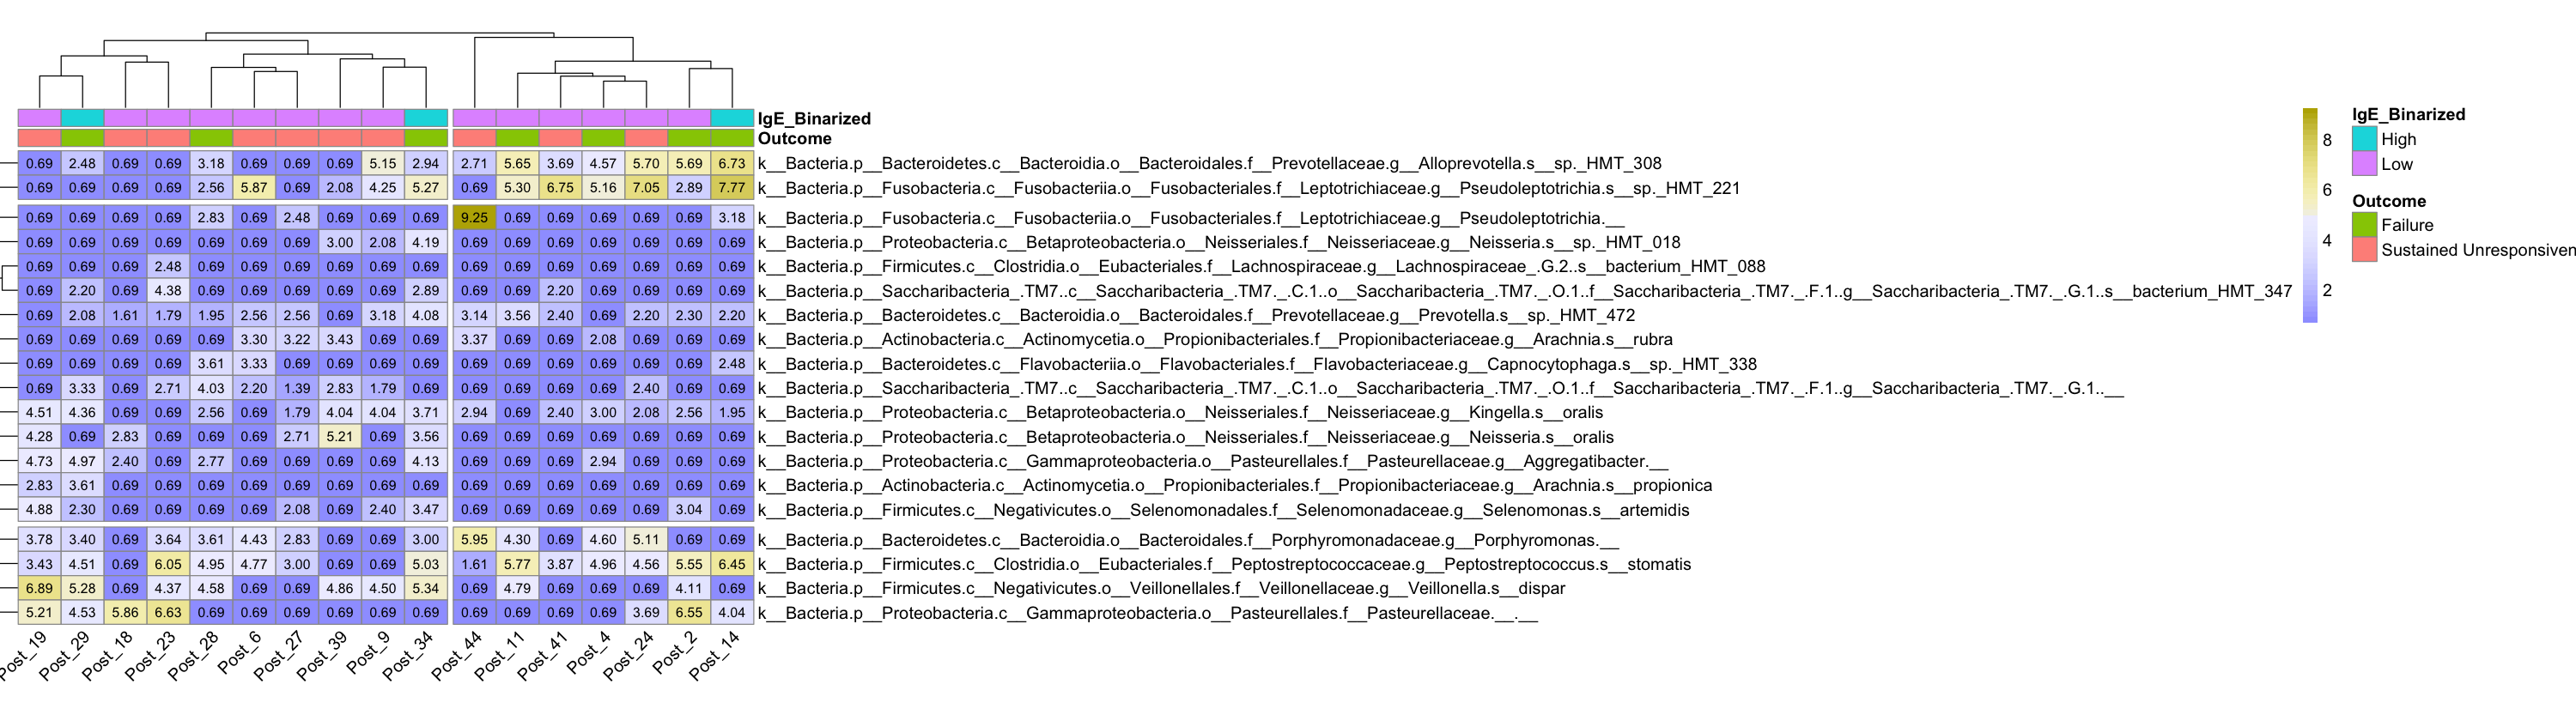

In [8]:
options(repr.plot.width=25, repr.plot.height=7) #changing size
pheatmap(t(post_saliva_df[,10:ncol(post_saliva_df)]), cluster_rows = TRUE, cluster_cols = TRUE, 
         angle_col = 45, fontsize = 12,  
         cellheight = 17, cellwidth = 30,
         color = hcl.colors(40, "Blue-Yellow 3"),
         display_numbers = TRUE, number_color = "black", 
         annotation_col = saliva_covariates_df,
         #annotation_legend = FALSE,
         cutree_row = 3, cutree_col = 2) # adds a break bewtween the largest clusters

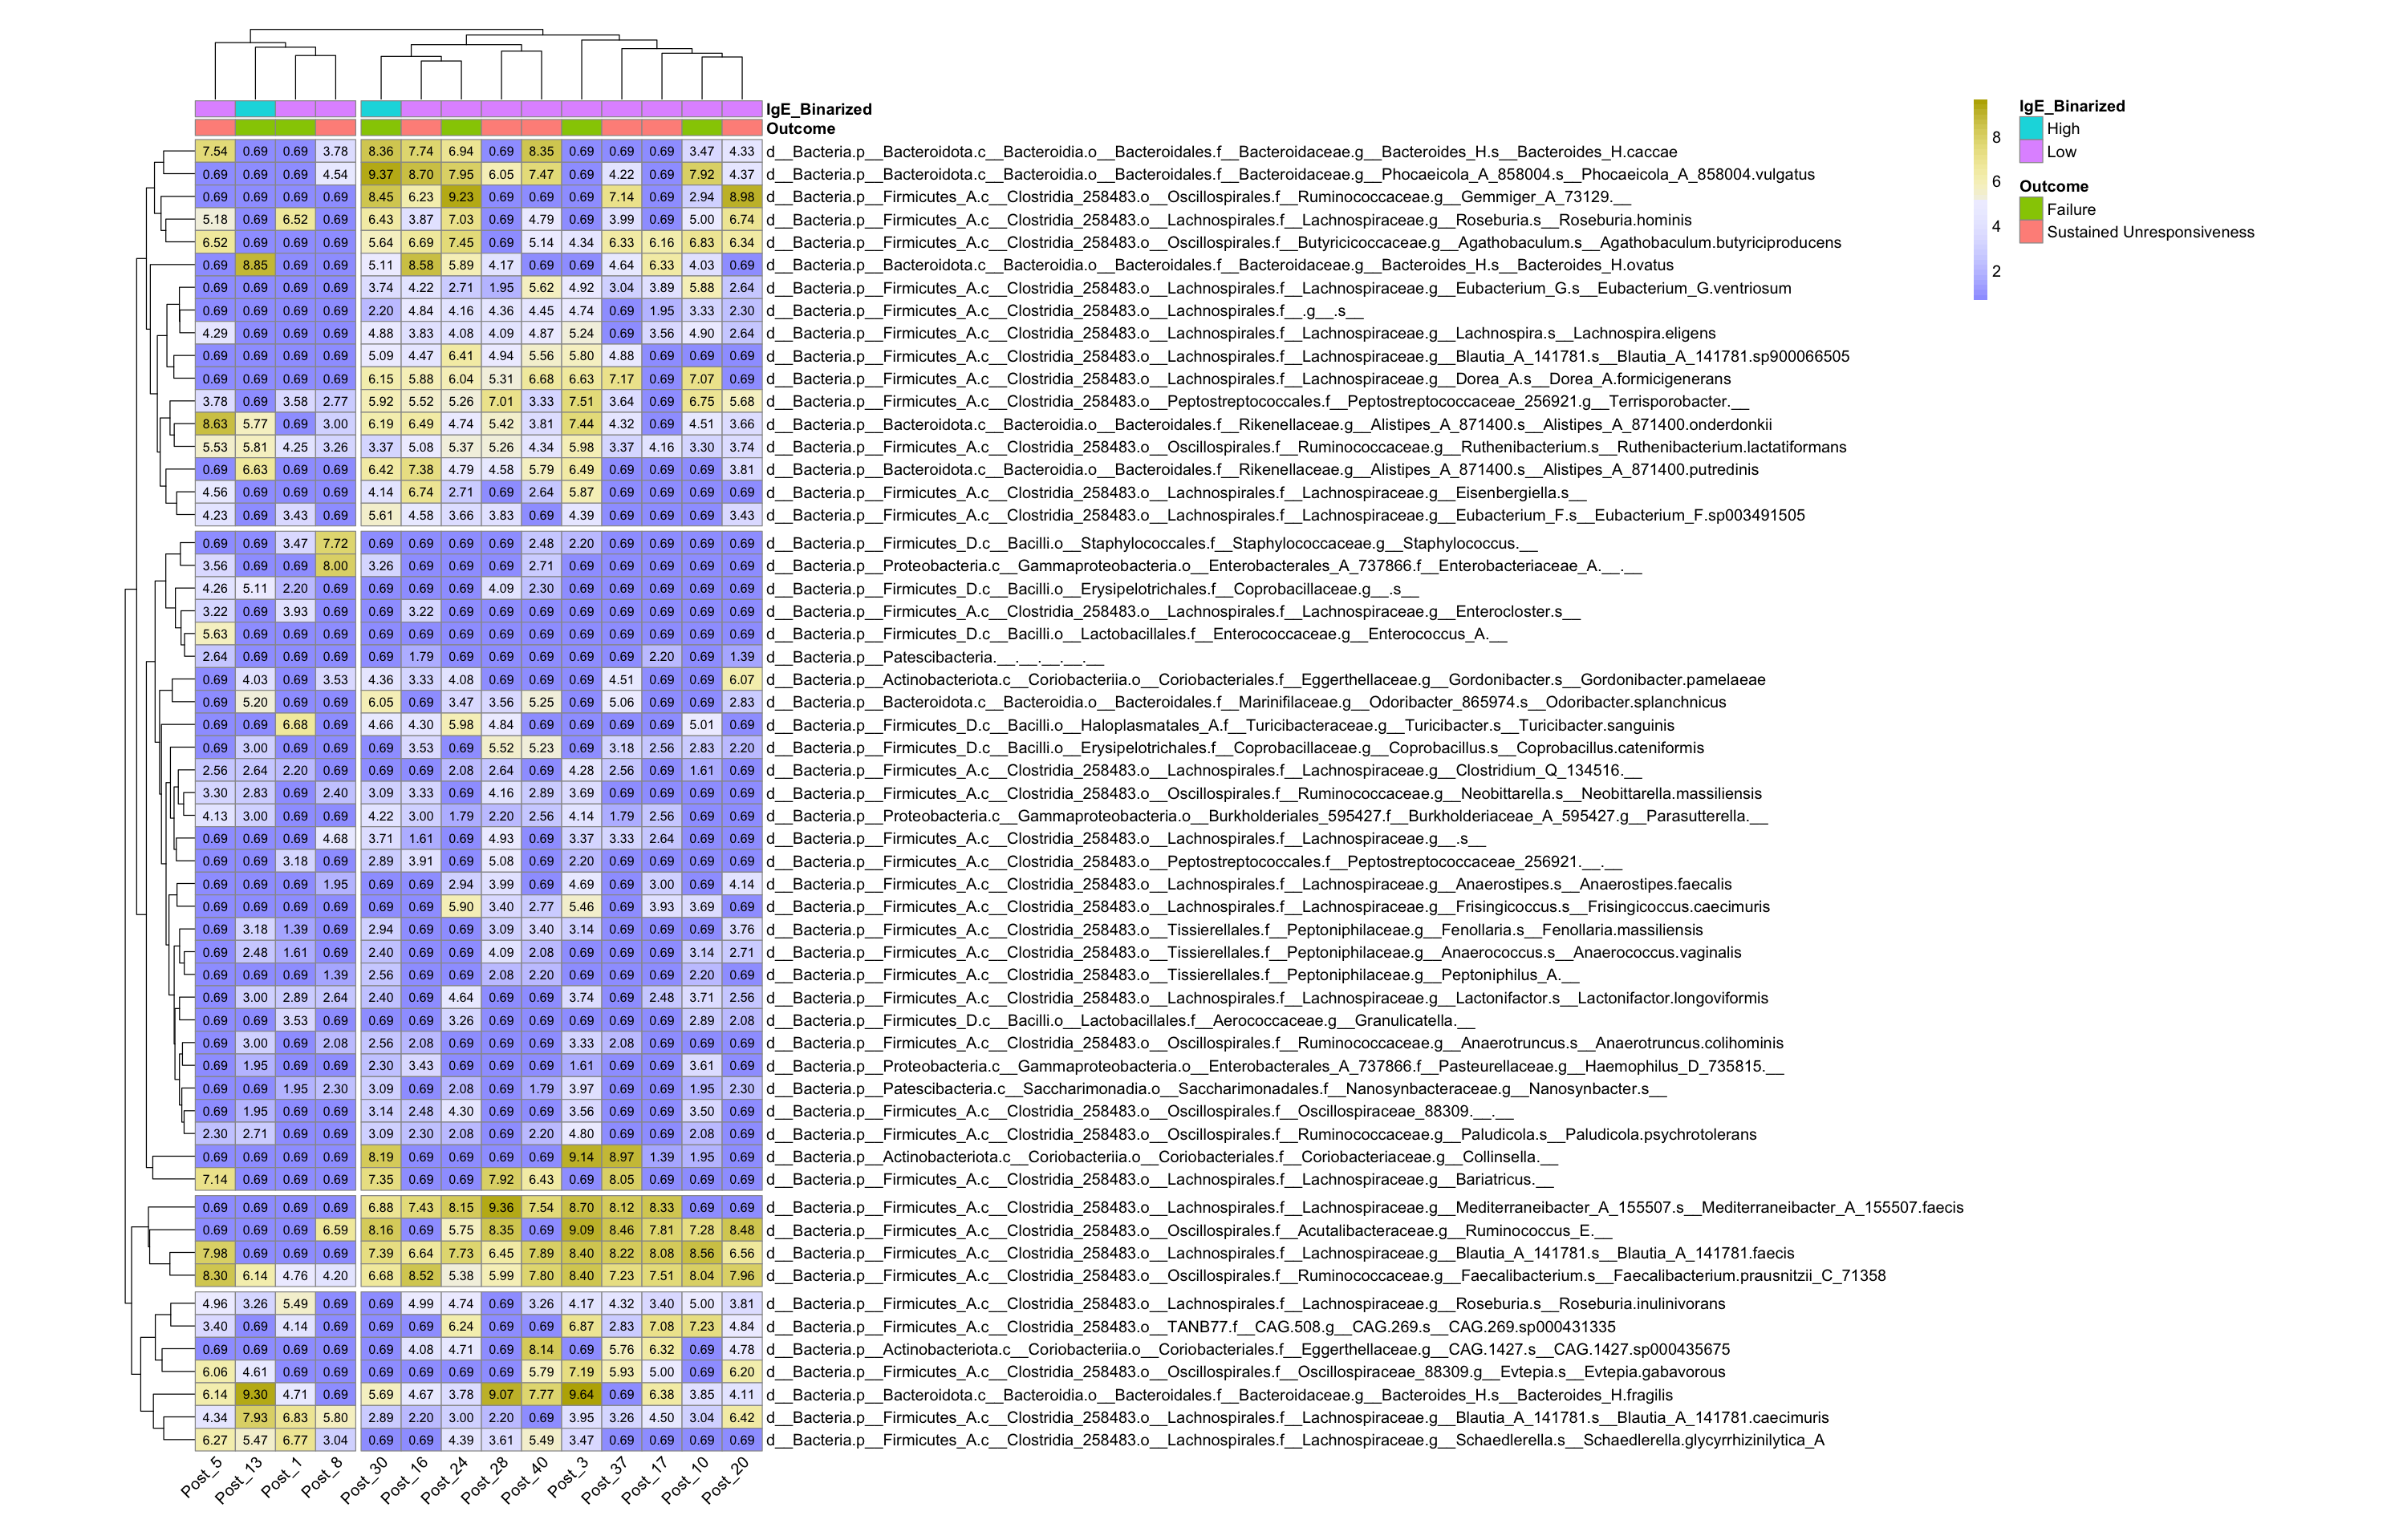

In [12]:
options(repr.plot.width=25, repr.plot.height=16) #changing size
pheatmap(t(post_stool_df[,10:ncol(post_stool_df)]), cluster_rows = TRUE, cluster_cols = TRUE, 
         angle_col = 45, fontsize = 12,  
         cellheight = 17, cellwidth = 30,
         color = hcl.colors(40, "Blue-Yellow 3"),
         display_numbers = TRUE, number_color = "black", 
         annotation_col = stool_covariates_df,
         #annotation_legend = FALSE,
         cutree_row = 4, cutree_col = 2) # adds a break bewtween the largest clusters